In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 200,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9814814814814815, Loss: 0.11993318133884007
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.1053283656084979
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.11425379470542625
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.11359046123645923
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.11402736769782172


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [2.9462295e-02 9.7048551e-01 5.2133342e-05]
[0. 0. 1.] <-> [1.0198930e-01 4.7895452e-04 8.9753175e-01]
[1. 0. 0.] <-> [0.6211801  0.00182532 0.37699455]
[1. 0. 0.] <-> [9.9778819e-01 1.4395161e-03 7.7226537e-04]
[1. 0. 0.] <-> [0.9746085  0.00164315 0.02374835]
[1. 0. 0.] <-> [9.958859e-01 3.270389e-03 8.436797e-04]
[1. 0. 0.] <-> [0.64885694 0.00185878 0.34928426]
[1. 0. 0.] <-> [9.9770987e-01 1.4313841e-03 8.5874362e-04]
[0. 1. 0.] <-> [6.8806605e-03 9.9310499e-01 1.4360947e-05]
[1. 0. 0.] <-> [0.7940718  0.00201124 0.20391698]
[0. 1. 0.] <-> [0.67462313 0.32459515 0.00078169]
[1. 0. 0.] <-> [9.9756289e-01 1.5552797e-03 8.8181824e-04]
[1. 0. 0.] <-> [9.935454e-01 5.700928e-03 7.536742e-04]
[1. 0. 0.] <-> [0.9976876  0.00130353 0.00100888]
[0. 0. 1.] <-> [9.0121394e-03 6.5870714e-05 9.9092191e-01]
[1. 0. 0.] <-> [0.9935097  0.00127272 0.00521753]
[1. 0. 0.] <-> [0.98473996 0.00150596 0.01375406]
[1. 0. 0.] <-> [0.9979323  0.00106917 0.00099863]
[1. 0. 0.] <-> [9.9731904

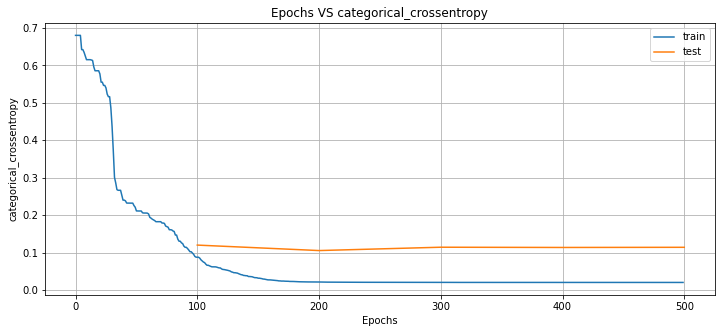

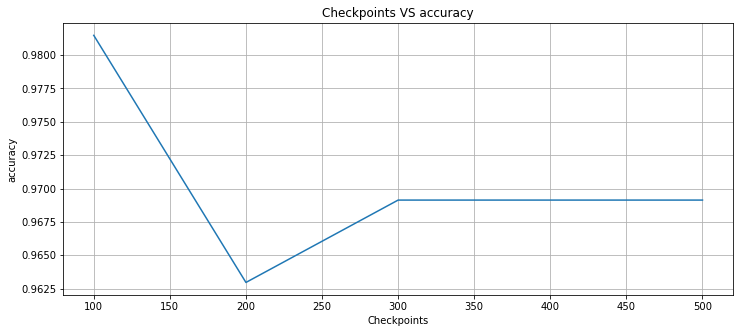

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9814814814814815, 'mean_square_error': 0.0551207715031838, 'categorical_crossentropy': 0.11993318133884007, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 2, 'tn_hit': 30, 'fn_hit': 1}, 1: {'tp_hit': 17, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 0}, 2: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.06683253871116841, 'categorical_crossentropy': 0.1053283656084979, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 5, 'tn_hit': 27, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.07155269276906152, 'categorical_crossentropy': 0.11425379470542625, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 5, 'tn_hit': 27, 'fn_hit': 0}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, '

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-1.1313775  3.         1.2155826 -3.        -1.3066491]
 bias: 3.0

Neuron 1: weights:
[ 1.9598113 -3.        -3.        -1.9585916  1.0297183]
 bias: 3.0

Neuron 2: weights:
[-1.9539367  3.         1.7808627  1.9002266 -1.3678112]
 bias: -3.0

Neuron 3: weights:
[-1.1553695  3.         1.3285336 -3.        -1.1442847]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[ 3.  3. -3.  3.]
 bias: -3.0

Neuron 1: weights:
[ 2.067904  -3.         3.         1.8230196]
 bias: -1.9188017845153809

Neuron 2: weights:
[-3.         1.8720101 -3.        -3.       ]
 bias: 2.828042984008789

$

